In [ ]:
# script that generates a button to hide all code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [7]:
experiment_list = (sql("""
    SELECT DISTINCT experiment_name
    FROM force_production.experiment_viewed
    WHERE experiment_name != 'partner_application_copy'
    AND experiment_name   != 'masonry_artwork_sort'
    AND experiment_name   != 'artwork_item_contact_gallery'
"""))

In [8]:
experiment_list

,experiment_name
0,personalized_homepage
1,redesigned_artwork_page


In [21]:
def format(experiments):
    return [x.replace('_',' ').title() for x in experiments.experiment_name.tolist()]

In [22]:
format(experiment_list)

[u'Personalizedhomepage', u'Redesignedartworkpage']

In [6]:
import os 
import warnings
warnings.simplefilter(action = "ignore", category = UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc as pm

from sqlalchemy import create_engine
engine_string = os.environ['REDSHIFT_CONN']
engine = create_engine(engine_string)

pd.options.display.max_columns=100
pd.options.mode.chained_assignment = None

#################################

# Displays a list of experiments to choose from, not that the first 3 we have logged are removed
# due to our mapped_experiments table not starting to build until May 10th. Before this,
# we were generating too many experiment events.

def sql(query):
    return pd.read_sql("%s" %query, engine)

# list of experiments in database
experiment_list = (sql("""
    SELECT DISTINCT experiment_name
    FROM force_production.experiment_viewed
    WHERE experiment_name != 'partner_application_copy'
    AND experiment_name   != 'masonry_artwork_sort'
    AND experiment_name   != 'artwork_item_contact_gallery'
"""))

# Variations; this is necessary because of of the inconsistencies in the experiments table for variation_name for the default group
defaults = ['default', 'original',
            'old_homepage_1', 'old_homepage_2', 'old_homepage_3', 'old_homepage_4', 'old_homepage_5']

def query_experiment_data(exp_name, start_date, end_date):

    # pulls the first and last experiment logged
    start_end = sql("""
        SELECT MIN(sent_at),
               MAX(sent_at)
        FROM force_production.experiment_viewed
        WHERE experiment_name = '%s'
    """%exp_name)

    # selects the value from the data frame
    first_log_of_exp = start_end.iloc[0]['min']
    last_log_of_exp = start_end.iloc[0]['max']

    # finds the start and end date
    print 'start date:                     ', first_log_of_exp
    print 'max date:                       ', last_log_of_exp
    print '-'*70

    # queries the experiment table
    exp = sql("""
        SELECT exp.variation_id,
               fins.*,
               SPLIT_PART(fins.session_id,' - ',1) as session_number
        FROM (SELECT DISTINCT session_id,
                     variation_id,
                     experiment_id
              FROM analytics.force_mapped_experiment_viewed afmev
              WHERE afmev.experiment_id = '%s') exp
          LEFT JOIN analytics.force_inquiry_funnel_sessions fins
                 ON exp.session_id = fins.session_id
                AND exp.variation_id is not null
        WHERE (session_start_at >= '%s' AND session_start_at <= '%s') LIMIT 5000000
    """%(exp_name, start_date, end_date))
    
    print
    print "experiment runs for " + str(exp.session_start_at.max()-exp.session_start_at.min())
    print '-'*70
    
    exp['date'] = exp.session_start_at.values.astype('datetime64[D]')
    exp['session_number'] = exp.session_number.values.astype(int)
    exp['outcome'] = (exp.inquiries > 0).astype('int')
    exp = exp.set_index('session_start_at').sort_index()
    
    return exp

def control_test_split(exp):
    control = exp.loc[exp.variation_id.isin(defaults)]
    test = exp.loc[~exp.variation_id.isin(defaults)]

    return control, test

def generate_metrics(control,test):
    control_lvid_positive = len(control.loc[control.inquiries>0].groupby('looker_visitor_id').inquiries.count())
    test_lvid_positive    = len(test.loc[test.inquiries>0].groupby('looker_visitor_id').inquiries.count())

    metrics = { 'number of uniques:': [control.looker_visitor_id.nunique(), test.looker_visitor_id.nunique()],
                'number of sessions': [len(control), len(test)],
                'uniques that have inquired': [control_lvid_positive, test_lvid_positive],
                'sessions resulting in inquiry': [control.outcome.sum(), test.outcome.sum()],
                'total artwork pageviews / uniques': [control.count_artwork_pv.sum()*1./control.looker_visitor_id.nunique(),test.count_artwork_pv.sum()*1./control.looker_visitor_id.nunique()],
                'sum of inquiries / # of sessions': [1.*control.inquiries.sum()/control.session_id.nunique(), 1.*test.inquiries.sum()/test.session_id.nunique()],
                'sum of inquiries / # of uniques': [1.*control.inquiries.sum() / control.looker_visitor_id.nunique(), 1.*test.inquiries.sum() / test.looker_visitor_id.nunique()],
                'avg inquiry rate per unique': [ 1.*int(control.groupby('looker_visitor_id').inquiries.mean().sum())/control.looker_visitor_id.nunique(), 1.*int(test.groupby('looker_visitor_id').inquiries.mean().sum())/test.looker_visitor_id.nunique()]
               }

    df_metrics = pd.DataFrame(metrics)
    cols = df_metrics.columns.tolist()
    cols = cols[1:] + cols[0:1]
    cols = cols[0:3] + cols[6:7] + cols[3:6] + cols[-1:]
    df_metrics = df_metrics[cols]
    df_metrics = df_metrics.T
    df_metrics.columns = [['control', 'test']]
    print df_metrics
    print

    control_sum = pd.DataFrame(control.ix[:,12:22].sum(), columns=['control'])
    test_sum = pd.DataFrame(test.ix[:,12:22].sum(), columns=['test'])
    print pd.merge(control_sum,test_sum,left_index=True,right_index=True)
    print 

    metrics = { 'positive LVID outcomes / uniques': [1.*control_lvid_positive/control.looker_visitor_id.nunique(),1.*test_lvid_positive/test.looker_visitor_id.nunique()],
                'positive sessions / total sessions': [1.*control.outcome.sum()/control.session_id.nunique(),1.*test.outcome.sum()/test.session_id.nunique()]
               }

    df_metrics = pd.DataFrame(metrics).T
    df_metrics.columns = [['control', 'test']]
    print df_metrics
    print '-'*70
    print

def cumulative_plot(test, control):
    # plots cumulative metrics from the inquiry_sessions funnel
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,16), sharex=True)
    plt.suptitle('Cumulative Metrics', fontsize=30); 
    # plt.style.use('classic')

    test.count_pv.cumsum().plot(ax=axes[0,0], title='pageviews', legend=True, label='test')
    control.count_pv.cumsum().plot(ax=axes[0,0], legend=True, label='control')

    test.count_artwork_pv.cumsum().plot(ax=axes[0,1], title='artwork pageviews', legend=True, label='test')
    control.count_artwork_pv.cumsum().plot(ax=axes[0,1], legend=True, label='control')

    test.count_artist_pv.cumsum().plot(ax=axes[1,0], title='artist pageviews', legend=True, label='test')
    control.count_artist_pv.cumsum().plot(ax=axes[1,0], legend=True, label='control')

    test.count_article_pv.cumsum().plot(ax=axes[1,1], title='article pageviews', legend=True, label='test')
    control.count_article_pv.cumsum().plot(ax=axes[1,1], legend=True, label='control')

    test.inquiries.cumsum().plot(ax=axes[2,0], title='inquiries', legend=True, label='test')
    control.inquiries.cumsum().plot(ax=axes[2,0], legend=True, label='control')

    test.accounts_created.cumsum().plot(ax=axes[2,1], title='accounts created', legend=True, label='test')
    control.accounts_created.cumsum().plot(ax=axes[2,1], legend=True, label='control')

    test.three_way_handshakes.cumsum().plot(ax=axes[3,0], title='three way handshakes', legend=True, label='test')
    control.three_way_handshakes.cumsum().plot(ax=axes[3,0], legend=True, label='control')

    test.three_way_handshakes_within_seven_days.cumsum().plot(ax=axes[3,1], title='three way handshakes within 7 days', legend=True, label='test')
    control.three_way_handshakes_within_seven_days.cumsum().plot(ax=axes[3,1], legend=True, label='control')

    test.purchases.cumsum().plot(ax=axes[4,0], title='purchases', legend=True, label='test')
    control.purchases.cumsum().plot(ax=axes[4,0], legend=True, label='control')

    test.total_purchase_price.cumsum().plot(ax=axes[4,1], title='total purchase price', legend=True, label='test')
    control.total_purchase_price.cumsum().plot(ax=axes[4,1], legend=True, label='control')
    
def daily_plot(test,control):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14), sharex=True)
    plt.suptitle('Daily Metrics', fontsize=30); 

    test.groupby('date')['count_pv'].sum().plot(kind='line', ax=axes[0,0], title='pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_pv'].sum().plot(kind='line', ax=axes[0,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['count_artwork_pv'].sum().plot(kind='line', ax=axes[0,1], title='artwork pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_artwork_pv'].sum().plot(kind='line', ax=axes[0,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['count_artist_pv'].sum().plot(kind='line', ax=axes[1,0], title='artist pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_artist_pv'].sum().plot(kind='line', ax=axes[1,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['count_article_pv'].sum().plot(kind='line', ax=axes[1,1], title='article pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_article_pv'].sum().plot(kind='line', ax=axes[1,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['inquiries'].sum().plot(kind='line',ax=axes[2,0], title='inquiries', legend=True, label='test', color='red')
    control.groupby('date')['inquiries'].sum().plot(kind='line',ax=axes[2,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['accounts_created'].sum().plot(kind='line', ax=axes[2,1], title='accounts created', legend=True, label='test', color='red')
    control.groupby('date')['accounts_created'].sum().plot(kind='line', ax=axes[2,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['three_way_handshakes'].sum().plot(kind='line', ax=axes[3,0], title='three way handshakes', legend=True, label='test', color='red')
    control.groupby('date')['three_way_handshakes'].sum().plot(kind='line', ax=axes[3,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['three_way_handshakes_within_seven_days'].sum().plot(kind='line', ax=axes[3,1], title='three way handshakes within 7 days', legend=True, label='test', color='red')
    control.groupby('date')['three_way_handshakes_within_seven_days'].sum().plot(kind='line', ax=axes[3,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['purchases'].sum().plot(kind='line', ax=axes[4,0], title='purchases', legend=True, label='test', color='red')
    control.groupby('date')['purchases'].sum().plot(kind='line', ax=axes[4,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['total_purchase_price'].sum().plot(kind='line', ax=axes[4,1], title='total purchase price', legend=True, label='test', color='red')
    control.groupby('date')['total_purchase_price'].sum().plot(kind='line', ax=axes[4,1], legend=True, label='control', color='steelblue')

def credible_intervals(control, test):

    # Bayesian approach to show the probability of the control being better or worse than the test
    # This looks at whether or not a user placed an inquiry - this avoids bias in people that send more inquiries

    first_inquiry_control = pd.DataFrame(control.loc[control.outcome ==1].
                                         groupby(['looker_visitor_id']).date.min().reset_index())
    first_inquiry_test = pd.DataFrame(test.loc[test.outcome ==1].
                                         groupby(['looker_visitor_id']).date.min().reset_index())
    first_inqs_per_day_control = first_inquiry_control.groupby('date').count()
    first_inqs_per_day_test = first_inquiry_test.groupby('date').count()

    # cumulative list of inquiries per day; only using the first inquiry from a given Looker Visitor ID
    inq_A = first_inqs_per_day_control.cumsum().looker_visitor_id.tolist()
    inq_B = first_inqs_per_day_test.cumsum().looker_visitor_id.tolist()

    # cumulative list of unique Looker Visitor IDs per day; only using the first observed instance
    control_A = pd.DataFrame(control.
                             groupby('looker_visitor_id').date.min().reset_index()).groupby('date')['looker_visitor_id'].count().cumsum().tolist()
    test_B = pd.DataFrame(test.
                          groupby('looker_visitor_id').date.min().reset_index()).groupby('date')['looker_visitor_id'].count().cumsum().tolist()

    #containers for HPD intervals
    hpds_A = []
    hpds_B = []

    # print '-'*30 + 'HPD intervals' + '-'*30

    # runs MCMC for each day the test is running; control_A has a value for each day in the test
    for i in range(0,len(control_A)):

    # assign distributions to my prior beliefs of p_A and p_B, the unknown, true conversion rates.
    # Assume uniform distribution (no prior knowledge of what p_A and 'p_B' are).
        p_A = pm.Uniform('p_A', lower=0, upper=1)
        p_B = pm.Uniform('p_B', lower=0, upper=1)

        # Since estimating the difference in true conversion rates, define a variable delta, which equals p_B - p_A.
        @pm.deterministic
        def delta(p_A=p_A, p_B=p_B):
            return p_B - p_A

    # To format this data for the analysis, create array with 1s representing inquiries and 0s representing no inquiries
    # np.r_ translates slice objects to concatenation along the first axis and allows us to build arrays quickly
    # If the index expression contains comma separated arrays, then stack them along their first axis.
    # If the index expression contains slice notation or scalars then create a 1-D array with a range indicated by the slice notation.

        data_A = np.r_[[0] * (control_A[i]- inq_A[i]), [1] * inq_A[i]]
        data_B = np.r_[[0] * (test_B[i] - inq_B[i]), [1] * inq_B[i]]

    # Add the observed data to PyMC variables and run MCMC for inference
        obs_A = pm.Bernoulli("obs_A", p_A, value = data_A, observed = True)
        obs_B = pm.Bernoulli("obs_B", p_B, value = data_B, observed = True)

        mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
        mcmc.sample(25000, 5000)

        p_A_samples = mcmc.trace("p_A")[:]
        p_B_samples = mcmc.trace("p_B")[:]
        delta_samples = mcmc.trace("delta")[:]

    # get HPD intervals
        hpd_A = pm.utils.hpd(p_A_samples, 1.-0.95)
        hpd_B = pm.utils.hpd(p_B_samples, 1.-0.95)

        hpds_A.append(hpd_A)
        hpds_B.append(hpd_B)
        print

    dfA = pd.DataFrame(hpds_A)
    dfB = pd.DataFrame(hpds_B)

    print
    # A 100(1-alpha)% HPD (highest posterior density) interval is a region that satisfies the following two conditions:
    #  1. The posterior probability of that region is 100(1-alpha)%.
    #  2. The minimum density of any point within that region is equal to or larger than the density of any point outside that region.

    # alpha is the tightness of the interval; the amount of probabilty mass excluded from the interval
    print mcmc.summary()

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,8), sharex=True)

    plt.fill_between(dfA.index, dfA[0], dfA[1], alpha=0.2, color='b')
    plt.fill_between(dfB.index, dfB[0], dfB[1], alpha=0.2, color='r')
    
    return p_A_samples, p_B_samples, delta_samples
    
def compare_posterior_distributions(p_A_samples, p_B_samples, delta_samples):
    from IPython.core.pylabtools import figsize

    figsize(12.5, 10)

    ax = plt.subplot(311)

    plt.xlim(0, p_A_samples.max()+.01)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.5,
    label="posterior of $p_A$", color="#A60628", normed=True,
    edgecolor= "none")
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

    ax = plt.subplot(312)

    plt.xlim(0, p_B_samples.max()+.01)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.5,
            label="posterior of $p_B$", color="#467821", normed=True,
            edgecolor = "none")
    plt.legend(loc="upper right")

    ax = plt.subplot(313)
    plt.ylim(0,120)
    plt.hist(delta_samples, histtype='stepfilled', bins=50, alpha=0.5,
            label="posterior of $p_B$ - $p_A$", color="#7A68A6",normed=True,
            edgecolor = "none")
    plt.legend(loc="upper right")
    plt.vlines(0, 0, 120, color="black", alpha = .5)

    plt.show()

    print "Probability control is BETTER than test: %.3f" %(delta_samples < 0).mean()
    print "Probability control is WORSE than test: %.3f" %(delta_samples > 0).mean()

In [2]:
print experiment_list
print 

# input for experiment name
exp_name = raw_input("type in an experiment name:      ")

# queries data from experiment
exp = query_experiment_data(exp_name)

# splits data into test and control buckets
control, test = control_test_split(exp)

# generates positive hits -- number of unique LVIDs that have placed inquiries
generate_metrics(control, test)

           experiment_name
0  redesigned_artwork_page
1    personalized_homepage

type in an experiment name:      personalized_homepage
start date:                      2016-07-15 15:41:08
max date:                        2016-08-16 12:42:37
----------------------------------------------------------------------
type in experiment start date:   2016-07-25 15:41:08
type in experiment end date:     2016-07-26 15:41:08

experiment runs for 0 days 23:59:09
----------------------------------------------------------------------
                                       control         test
number of sessions                 1624.000000  1615.000000
number of uniques:                 1523.000000  1515.000000
sessions resulting in inquiry         6.000000     7.000000
uniques that have inquired            6.000000     7.000000
sum of inquiries / # of sessions      0.003695     0.004954
sum of inquiries / # of uniques       0.003940     0.005281
total artwork pageviews / uniques     1.282337     1

 [-----------------100%-----------------] 25000 of 25000 complete in 2.5 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 2.9 sec


delta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.001            0.003            0.0              [-0.004  0.006]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.004           -0.001          0.001          0.002         0.006
	

p_B:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.005            0.002            0.0              [ 0.002  0.009]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.002            

/Users/oliver/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


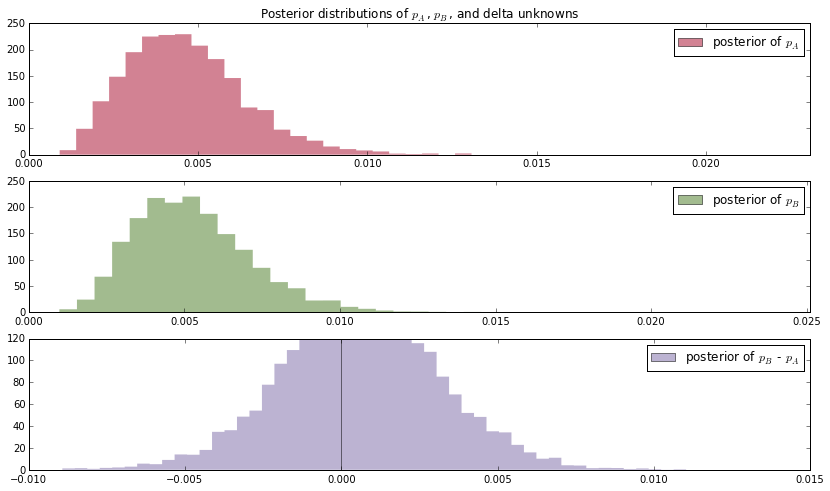

Probability control is BETTER than test: 0.400
Probability control is WORSE than test: 0.601


In [3]:
p_A_samples, p_B_samples, delta_samples = credible_intervals(control, test)
compare_posterior_distributions(p_A_samples, p_B_samples, delta_samples)

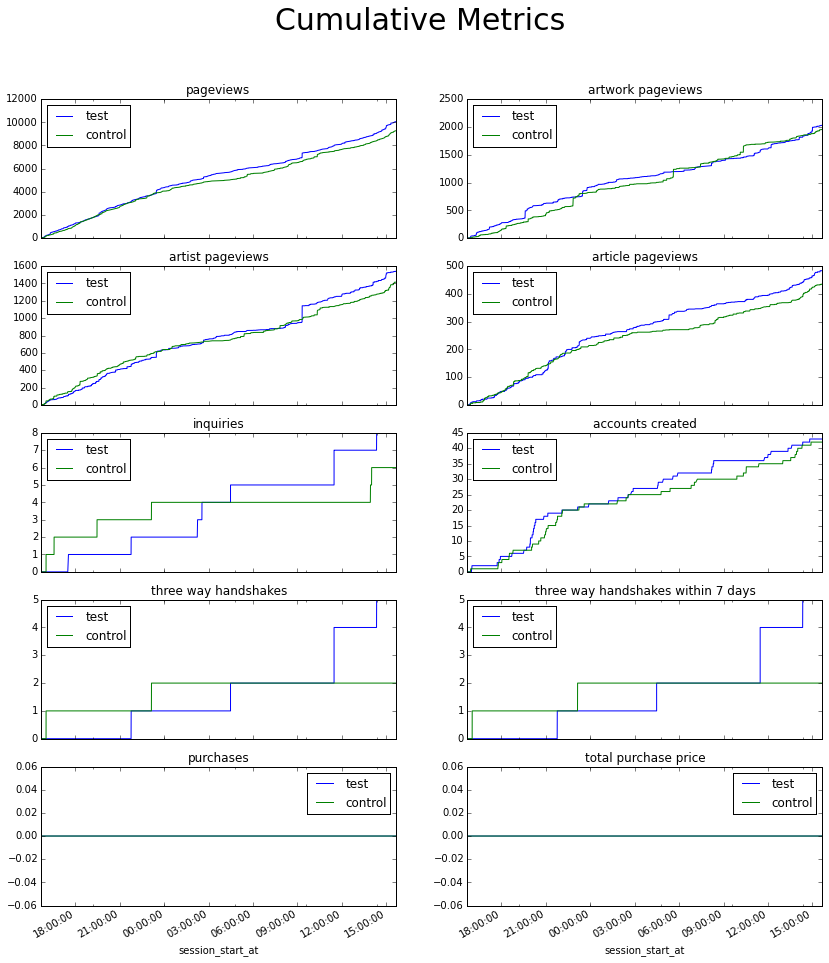

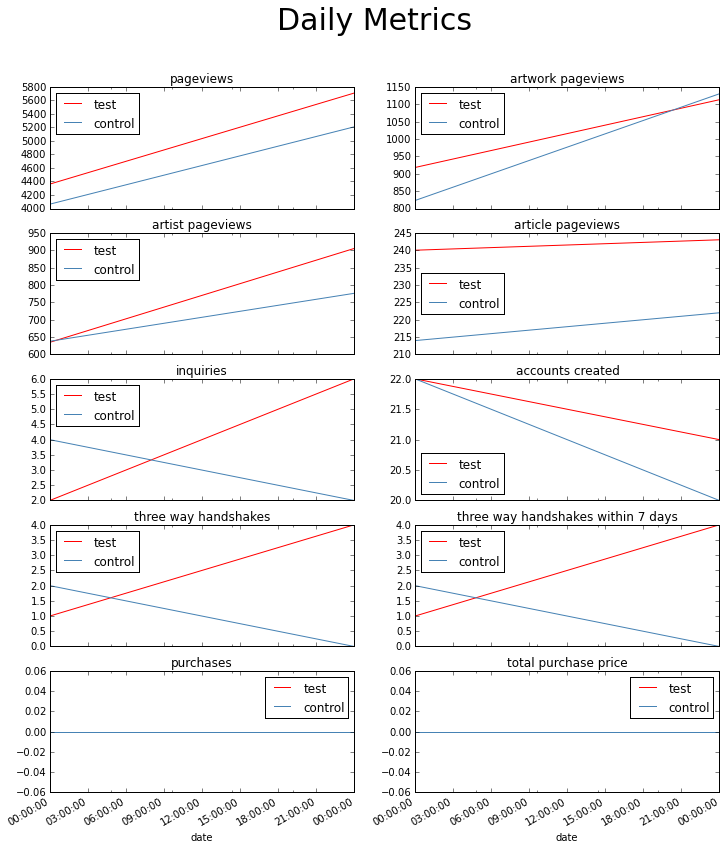

In [4]:
# cumulative plots
cumulative_plot(test, control)

# daily plots
daily_plot(test, control)

(1, 50)

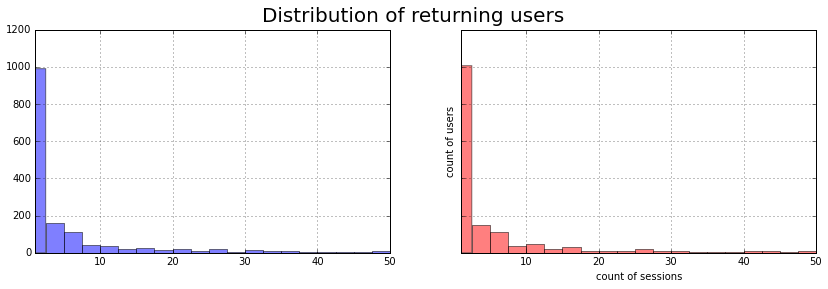

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharex=True, sharey=True)
plt.suptitle('Distribution of returning users', fontsize=20); 
plt.ylabel('count of users')
plt.xlabel('count of sessions')

control.session_number.astype(float).hist(ax=axes[0], bins=20,range=(0,50),alpha=0.5,color='b')
plt.xlim([1,50])

test.session_number.astype(float).hist(ax=axes[1], bins=20,range=(0,50),alpha=0.5,color='r')
plt.xlim([1,50])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

test_sums = test.loc[test.session_number==1].groupby('looker_visitor_id')[['count_artwork_pv', 'inquiries']].sum()
test_sums.inquiries.sort_values(ascending=False).head(50).hist(ax=axes[0], figsize=(13,5), alpha=0.5, color='r')
test_sums.count_artwork_pv.sort_values(ascending=False).head(50).hist(ax=axes[1], figsize=(13,5), alpha=0.5, color='r')

plt.suptitle('First Session - Inquiries (Left) and Artwork Pageviews (Right) for Top 50 Descending', fontsize=20); 

In [ ]:
print 'control: ', control[control.purchases>0][['looker_visitor_id','count_pv','total_purchase_price']]
print 'test:    ', test[test.purchases>0][['looker_visitor_id','count_pv','total_purchase_price']]

In [ ]:
exp_logged_status = sql("""
    SELECT exp.variation_id,
           fins.*,
           SPLIT_PART(fins.session_id,' - ',1) as session_number,
           afmps.logged_in
    FROM (SELECT DISTINCT session_id,
                 variation_id,
                 experiment_id
          FROM analytics.force_mapped_experiment_viewed afmev
          WHERE afmev.experiment_id = '%s') exp
      LEFT JOIN analytics.force_inquiry_funnel_sessions fins
             ON exp.session_id = fins.session_id
            AND exp.variation_id is not null
      LEFT JOIN (select distinct session_id,
                        logged_in
                from analytics.force_mapped_pages) afmps
                on afmps.session_id = fins.session_id
    WHERE (session_start_at >= '%s' AND session_start_at <= '%s') LIMIT 5000000
"""%('personalized_homepage', '2016-07-21', '2016-08-09'))

exp_logged_status['date'] = exp_logged_status.session_start_at.values.astype('datetime64[D]')
exp_logged_status['outcome'] = (exp_logged_status.inquiries > 0).astype('int')
exp_logged_status = exp_logged_status.set_index('session_start_at').sort_index()

In [ ]:
exp_logged_status.groupby('logged_in').sum()

In [ ]:
control_logged_status = exp_logged_status.loc[exp_logged_status.variation_id.isin(defaults)]
test_logged_status = exp_logged_status.loc[~exp_logged_status.variation_id.isin(defaults)]

In [ ]:
control_logged_status.groupby('logged_in').sum()

In [ ]:
test_logged_status.groupby('logged_in').sum()

We have more purchases in the full data set - selecting distinct `session_id` from `force_mapped_pages` is filtering out information

In [ ]:
control_logged_status.groupby(['logged_in','outcome']).sum()

In [ ]:
test_logged_status.groupby(['logged_in','outcome']).sum()

In [ ]:
exp_logged_status[exp_logged_status.session_id == '2 - 570c28658b3b817d2d003a14']

In [ ]:
print 'total sessions in original df:              ', (25624.000000 + 25862.000000)
print 'total sessions after considering logged-in: ', len(exp_logged_status)

In [ ]:
control_logged_status.groupby(['logged_in','outcome','variation_id']).sum()

In [ ]:
test_logged_status.groupby(['logged_in','outcome','variation_id']).sum()

In [ ]:
both_logged = exp_logged_status.groupby('session_id').logged_in.nunique()

In [ ]:
both_logged = both_logged[both_logged > 1]

In [ ]:
len(both_logged)

In [ ]:
exp_logged_status[exp_logged_status.session_id.isin(both_logged.index)]

In [ ]:
sessions_during_exp = exp.groupby('looker_visitor_id').session_number.nunique()

In [ ]:
len(sessions_during_exp)

In [ ]:
for i in range(1,21):
    print '# users with %s sessions: '%i , len(sessions_during_exp[sessions_during_exp == i])

In [ ]:
for i in range(0,21):
    print '# users with more than %s sessions: '%i , len(sessions_during_exp[sessions_during_exp > i])

In [ ]:
pd.Series([len(sessions_during_exp[sessions_during_exp > i]) for i in range(1,22)]).plot(kind='bar',
                                                                                         color='plum',
                                                                                         alpha=0.5)

# change the value below to compare

In [ ]:
more_than_one_session = sessions_during_exp[sessions_during_exp > 5]

In [ ]:
len(more_than_one_session)

In [ ]:
df_multi_sessions = exp[exp.looker_visitor_id.isin(more_than_one_session.index)]

In [ ]:
defaults = ['default', 'original',
            'old_homepage_1', 'old_homepage_2', 'old_homepage_3', 'old_homepage_4', 'old_homepage_5']

In [ ]:
control_more_than_one_session = df_multi_sessions[df_multi_sessions.variation_id.isin(defaults)]

In [ ]:
test_more_than_one_session = df_multi_sessions[~df_multi_sessions.variation_id.isin(defaults)]

In [ ]:
control_more_than_one_session[control_more_than_one_session.session_number > 50]._get_numeric_data().mean()

In [ ]:
test_more_than_one_session[test_more_than_one_session.session_number > 50]._get_numeric_data().mean()

In [ ]:
control_more_than_one_session._get_numeric_data().mean()

In [ ]:
test_more_than_one_session._get_numeric_data().mean()

In [ ]:
control_more_than_one_session.exit_page_path.value_counts()[control_more_than_one_session.exit_page_path.value_counts()>=15]

In [ ]:
test_more_than_one_session.exit_page_path.value_counts()[test_more_than_one_session.exit_page_path.value_counts()>=15]

In [ ]:
homepage_pv = sql("""
SELECT sent_at::DATE,
       looker_visitor_id,
       logged_in, --might not be necessary
       COUNT(*)
FROM analytics.force_pages
WHERE (event IN ('/','')
OR    event IS NULL)
AND sent_at >= '2016-07-21'
GROUP BY 1,
         2,
         3  --might not be necessary
ORDER BY sent_at::DATE DESC
""")

In [ ]:
homepage_pv.sent_at = homepage_pv.sent_at.values.astype('datetime64[D]')

In [ ]:
control.date.head()

In [ ]:
homepage_pv.head()

In [ ]:
control_with_homepage = pd.merge(control, homepage_pv, how='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])
test_with_homepage    = pd.merge(test, homepage_pv, how ='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])

In [ ]:
# control_with_homepage = pd.merge(control, homepage_pv, how='left', on='looker_visitor_id')
# test_with_homepage    = pd.merge(test, homepage_pv, how ='left', on='looker_visitor_id')

In [ ]:
control_with_homepage.groupby('looker_visitor_id').sum().mean()

In [ ]:
test_with_homepage.groupby('looker_visitor_id').sum().mean()

In [ ]:
control_homepage_more_than_one_session = pd.merge(control_more_than_one_session, homepage_pv, how='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])
test_homepage_more_than_one_session = pd.merge(test_more_than_one_session, homepage_pv, how='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])

In [ ]:
test_with_homepage.looker_visitor_id.nunique()

In [ ]:
print len(control_homepage_more_than_one_session)
print len(test_homepage_more_than_one_session)

In [ ]:
control_homepage_more_than_one_session.groupby('looker_visitor_id').sum().mean()

In [ ]:
test_homepage_more_than_one_session.groupby('looker_visitor_id').sum().mean()

In [ ]:
control_homepage_more_than_one_session[control_homepage_more_than_one_session.logged_in==False].groupby('looker_visitor_id').sum().mean()

In [ ]:
test_homepage_more_than_one_session[test_homepage_more_than_one_session.logged_in==False].groupby('looker_visitor_id').sum().mean()

In [ ]:
control_homepage_more_than_one_session[control_homepage_more_than_one_session.logged_in==True].groupby('looker_visitor_id').sum().mean()

In [ ]:
test_homepage_more_than_one_session[test_homepage_more_than_one_session.logged_in==True].groupby('looker_visitor_id').sum().mean()

In [ ]:
test_session_logged_in = test_homepage_more_than_one_session[test_homepage_more_than_one_session.logged_in==True][test_homepage_more_than_one_session.session_number>50]

In [ ]:
test_session_logged_in.groupby('looker_visitor_id').sum().mean()